<a href="https://colab.research.google.com/github/GeorgeAdrock/BolsaTrabajo_CienciaDatos/blob/main/Copia_de_6_1_at_text_classification_machine_learning_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chile - Universidad Adolfo Ibáñez (UAI)
##Curso Analítica Textual
### Text Classification - Spam Detection (Inglés)

# Carga & Exploración de Datos

In [ ]:
#Importar Librerías
import pandas as pd
import numpy as np
import spacy

In [ ]:
#Carga de Datos
df = pd.read_csv("spam_classification.csv")

In [ ]:
#Verificar Columns
df.columns

Index(['category', 'Message'], dtype='object')

In [ ]:
#Verificar Tamaño
df.shape

(5572, 2)

In [ ]:
#Verificar Contenido
df.head()

,category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#Generar Label Spam (Binario)
df['label'] = np.where(df['category'] == "spam", 1, 0)

In [ ]:
#Verificar Distribución Label
df['label'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

# Pre-Procesamiento

In [ ]:
#Descargar spaCy pipeline
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.8 MB 38.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
#Cargar Pipeline
nlp = spacy.load("en_core_web_sm")

In [ ]:
#Función para Pre-Processing + Tokenización
def get_tokens(text):
  doc = nlp(text)
  tokens = [token.lemma_.lower() for token in doc if token if not token.is_stop and not token.is_punct and not token.like_url and not token.like_email]
  return tokens

# Modelo Bag of Words & LSA

In [ ]:
#Importar Librerías
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
#Crear Objeto TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=None,
                                   preprocessor=None, 
                                   tokenizer=get_tokens)

In [ ]:
#Ajustar TfidfVectorizer a Mensajes
tfidf_vectorizer.fit(df['Message'])
print("Tamaño Vocabulario:", len(tfidf_vectorizer.get_feature_names_out()))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Tamaño Vocabulario: 7957


In [ ]:
#Generar Representación Vectorial
tfidf_vectors = tfidf_vectorizer.transform(df['Message'])
print("Dimensionalidad Rep. Vectorial:", tfidf_vectors.shape)

Dimensionalidad Rep. Vectorial: (5572, 7957)


In [ ]:
#Parametrización & Ajuste Objeto SVD
n_components = 1000
SVD = TruncatedSVD(n_components=n_components,
                   random_state=0)
SVD = SVD.fit(tfidf_vectors)

In [ ]:
#Resumen Varianza Explicada
print("Total Varianza Explicada:", round(SVD.explained_variance_ratio_.sum(),3))

Total Varianza Explicada: 0.736


In [ ]:
#Transformación Matriz Rep. Vectorial
tfidf_lsa_vectors = SVD.transform(tfidf_vectors)
print("Dimensionalidad Rep. Vectorial:", tfidf_lsa_vectors.shape)

Dimensionalidad Rep. Vectorial: (5572, 1000)


# Train & Test Sets

In [ ]:
#Importar Librerías
from sklearn.model_selection import train_test_split

In [ ]:
#Creación Vector Labels
labels = np.array(df['label'])

In [ ]:
#Creación Train & Test Set
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(tfidf_lsa_vectors, labels, 
                                                    train_size = train_size, 
                                                    random_state=0, 
                                                    stratify = labels)

In [ ]:
#Validar Tamaño Datasets
print('Train Set: X', X_train.shape, '- Y: ',y_train.shape)
print('Test Set: X', X_test.shape, '- Y: ',y_test.shape)

Train Set: X (4457, 1000) - Y:  (4457,)
Test Set: X (1115, 1000) - Y:  (1115,)


# KNN

In [ ]:
#Importar Librerías
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#k-NN (Hyper-Parameter Tuning)

clf_kNN_grid = KNeighborsClassifier()
param_grid_kNN = [{'n_neighbors': list(range(2,10,1))}]

clf_kNN_ht = GridSearchCV(estimator = clf_kNN_grid, 
                          param_grid = param_grid_kNN, 
                          n_jobs = -1, 
                          scoring="recall_micro")

clf_kNN_ht.fit(X_train, y_train)

print('Best Parameters: \n', clf_kNN_ht.best_params_)

Best Parameters: 
 {'n_neighbors': 3}


In [ ]:
#Entrenamiento K-NN (Mejor Hiper-Parámetro)
clf_kNN = KNeighborsClassifier(n_neighbors = clf_kNN_ht.best_params_['n_neighbors'])
clf_kNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#Validación Cruzada (Train Set)
cross_val_scores = cross_validate(clf_kNN, X_train, y_train, cv=5, scoring=['f1'])
print('Promedio F1-Score:', round(cross_val_scores['test_f1'].mean(),3))
print('Desviación F1-Score:', round(cross_val_scores['test_f1'].std(),3))

Promedio F1-Score: 0.69
Desviación F1-Score: 0.02


In [ ]:
#Predicción Test Set
y_pred_KNN = clf_kNN.predict(X_test)

In [ ]:
#Evaluación Test Set
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred_KNN))
print('F1 Score:', round(f1_score(y_test, y_pred_KNN),3))

Confusion Matrix:
 [[964   2]
 [ 76  73]]
F1 Score: 0.652


# Decision Curve Analysis

In [ ]:
#Importar Código DCA
from dca_ml import *

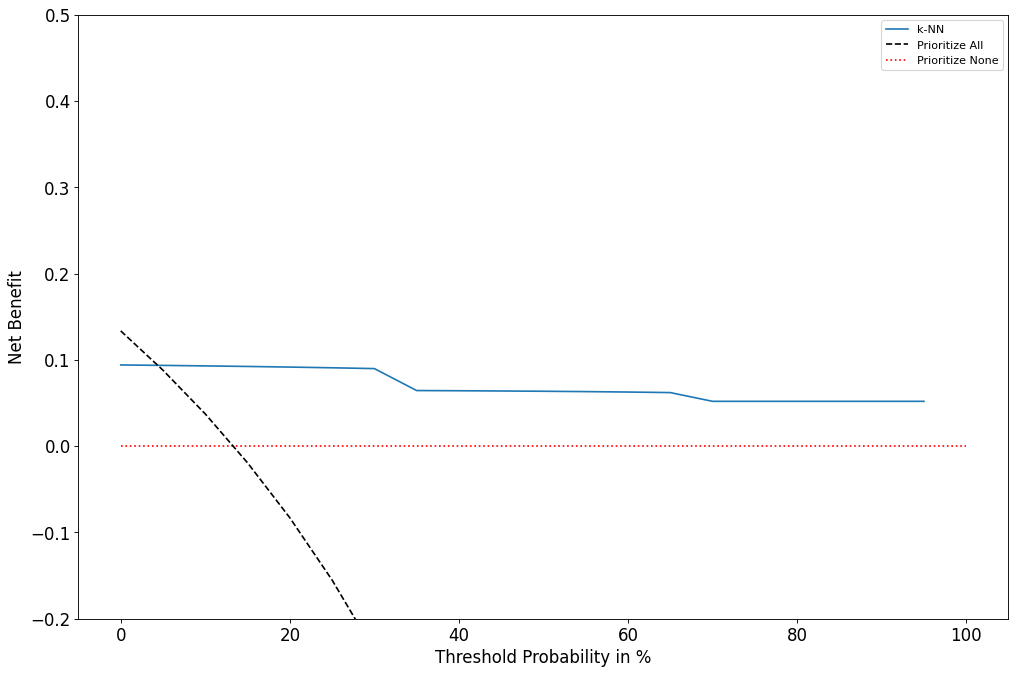

In [ ]:
#Plotting Decision Curve Analysis

clfs = [clf_kNN]
names = ['k-NN']
p_min = 0.0
p_max = 1.00
epsilon = 0.05

plot_decision_curves(clfs, names, X_test, y_test, p_min, p_max, epsilon)

# SVM

In [ ]:
#Importar Librerías
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import decomposition

from sklearn.preprocessing import LabelEncoder

In [ ]:
#SVM(Hyper-Parameter Tuning)

clf_SVN_grid = SVC()
# defining parameter range
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]



clf_SVC_ht = GridSearchCV(estimator = clf_SVN_grid, 
                          param_grid = tuned_parameters, 
                          n_jobs = -1, 
                          refit = True, verbose = 3,
                          scoring="f1")

clf_SVC_ht.fit(X_train, y_train)

# print best parameter after tuning
print(clf_SVC_ht.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(clf_SVC_ht.best_estimator_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [ ]:
clf_SVC_ht.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:

my_svm = SVC(C=100, kernel="rbf",  probability=True)
my_svm.fit(X_train, y_train)


SVC(C=100, probability=True)

In [ ]:
#Validación Cruzada (Train Set)
cross_val_scores = cross_validate(my_svm, X_train, y_train, cv=5, scoring=['f1'])
print('Promedio F1-Score:', round(cross_val_scores['test_f1'].mean(),3))
print('Desviación F1-Score:', round(cross_val_scores['test_f1'].std(),3))

Promedio F1-Score: 0.936
Desviación F1-Score: 0.009


In [ ]:
#Predicción Test Set
y_pred_SVM = my_svm.predict(X_test)

In [ ]:
#Evaluación Test Set
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred_SVM))
print('F1 Score:', round(f1_score(y_test, y_pred_SVM),3))

Confusion Matrix:
 [[965   1]
 [ 26 123]]
F1 Score: 0.901


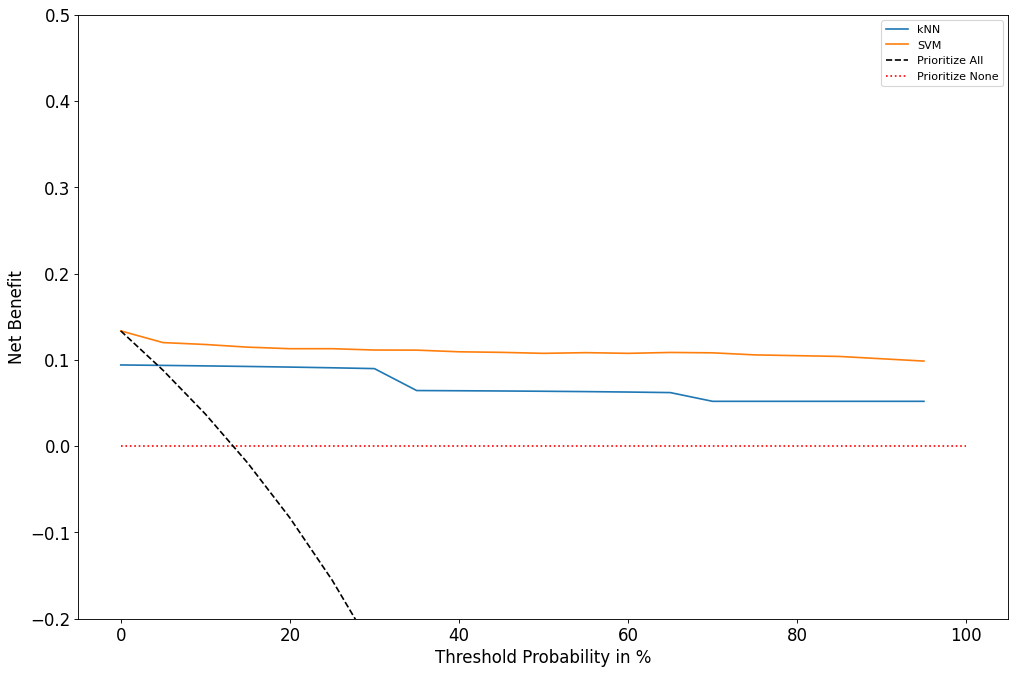

In [ ]:
#Plotting Decision Curve Analysis

clfs = [clf_kNN,my_svm]
names = ['kNN','SVM']
p_min = 0.0
p_max = 1.00
epsilon = 0.05

plot_decision_curves(clfs, names, X_test, y_test, p_min, p_max, epsilon)